# Normalizing Input QSO Spectra

In [2]:
%pylab inline

import os, sys, glob, json, pickle

from astropy.table import Table
import numpy as np
import fitsio

Populating the interactive namespace from numpy and matplotlib


In [2]:
#- Read the input data and confirm dimensions

basedir = '/global/cfs/cdirs/desi/users/rdoshi99/desi_qso_templates/data_v6/selected_spectra'
flux = pickle.load(open(basedir+'/fluxes.pkl', 'rb'))
ivar = pickle.load(open(basedir+'/ivars.pkl', 'rb'))
qsocat = Table.read(basedir+'/qsocat0.fits')

loglam_file = basedir+'rest_loglams.pkl'
if os.path.exists(loglam_file):
    loglam = pickle.load(open(basedir+'/selected_spectra/rest_loglams.pkl', 'rb'))
else:
    #- make something up that isn't too wrong, only for testing on earlier datasets
    print('WARNING: making up wavelength array')
    loglam = 2.6 + 0.0001*np.arange(flux.shape[1])

wave = 10**loglam

nspec, nwave = flux.shape
assert flux.shape == ivar.shape
assert len(qsocat) == nspec
assert len(loglam) == nwave

zmin = np.min(qsocat['Z'])
zmax = np.max(qsocat['Z'])

print(f'Starting with {nspec} targets covering {nwave} wavelengths from redshift {zmin:.2f} to {zmax:.2f}')

Starting with 27723 targets covering 14000 wavelengths from redshift 0.03 to 7.00


In [3]:
#- Sort by redshift
ii = np.argsort(qsocat['Z'])
qsocat = qsocat[ii]
flux = flux[ii]
ivar = ivar[ii]

In [4]:
#- Trim to wavelengths with coverage

#- there should be 0 or 1 transitions from "don't keep" to "keep",
#- and 0 or 1 transitions back from "keep" to "don't keep".
#- If not, we have to do more work for exactly which wavelengths to keep to maintain the uniform loglam steps
keepwave = (np.sum(ivar>0, axis=0) > 0)
dkeep = np.diff(keepwave.astype(int))
assert np.count_nonzero(dkeep == 1) <= 1
assert np.count_nonzero(dkeep == -1) <= 1

print('Removing {} wavelengths with no coverage'.format(np.sum(~keepwave)))
flux = flux[:, keepwave]
ivar = ivar[:, keepwave]
wave = wave[keepwave]
loglam = loglam[keepwave]

Removing 489 wavelengths with no coverage


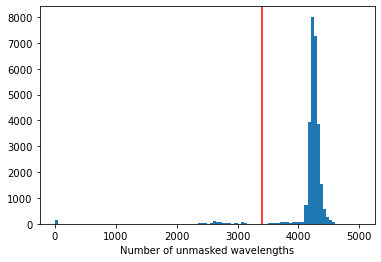

In [5]:
#- Drop targets with less than 80% of the median number of unmasked wavelengths
coverage = np.sum(ivar>0, axis=1)
nwave_threshold = 0.8 * np.median(coverage)
hist(coverage, 100, (0, 5000))
axvline(nwave_threshold, color='r')
xlabel('Number of unmasked wavelengths');

In [6]:
keep = coverage > nwave_threshold
nbad = np.count_nonzero(keep == False)
print(f'Dropping {nbad} targets with low wavelength coverage')
flux = flux[keep]
ivar = ivar[keep]
qsocat = qsocat[keep]

Dropping 722 targets with low wavelength coverage


In [7]:
nspec, nwave = flux.shape
zmin = np.min(qsocat['Z'])
zmax = np.max(qsocat['Z'])
print(f'Proceeding with {nspec} targets covering {nwave} wavelengths from redshift {zmin:.2f} to {zmax:.2f}')

Proceeding with 27001 targets covering 13511 wavelengths from redshift 0.03 to 7.00


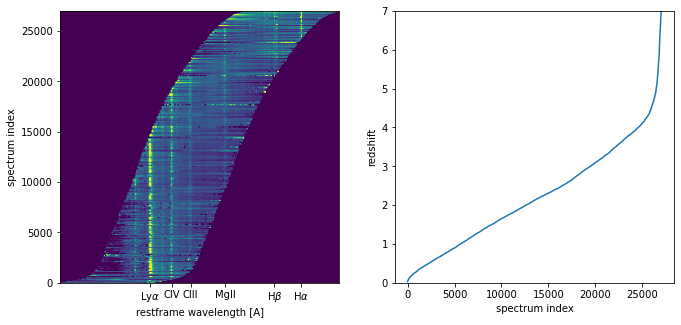

In [8]:
#- Plot the input spectra; only show every 100th spectrum since thousands of them won't fit anyway

figure(figsize=(11,5))
subplot(121)
imshow(flux[0::100], vmin=0, vmax=2, aspect='auto', extent=(loglam[0], loglam[-1], 0, nspec))
ww = np.array([1216, 1549, 1909, 2798, 4861, 6563])
emission_lines = [r'Ly$\alpha$', 'CIV', 'CIII', 'MgII', r'H$\beta$', r'H$\alpha$']
xticks(np.log10(ww), emission_lines)
xlabel('restframe wavelength [A]')
ylabel('spectrum index')

subplot(122)
plot(qsocat['Z'])
xlabel('spectrum index')
ylabel('redshift')
ylim(0,7);

# Normalize the spectra

Summary of the algorithm:
  * Split the spectra into N groups (default 5) grouped by redshift
  * Calculate the mean spectrum of each group
  * Normalize the mean spectra to each other, using the wavelengths that are covered both mean spectra in neighboring groups
  * Form a new mean spectrum by combining the means of all the groups
  * Normalize the individual spectra to that mean spectrum

In [9]:
ngroups = 50
iigroup = np.array_split(np.arange(nspec), ngroups)
meanflux = np.zeros((ngroups, nwave))

for i, ii in enumerate(iigroup):
    nspec_per_wave = np.sum(ivar[ii]>0, axis=0)
    jj = nspec_per_wave > 0.5 * np.max(nspec_per_wave)
    
    zmin = np.min(qsocat['Z'][ii])
    zmax = np.max(qsocat['Z'][ii])
    n = len(ii)
    njj = np.count_nonzero(jj)
    # print(f'Group {i:2d} with {n} spectra with {njj} wavelengths covering z={zmin:.2f}-{zmax:.2f}')
    meanflux[i, jj] = np.average(flux[ii][:, jj], weights=ivar[ii][:,jj]>0, axis=0)

CPU times: user 4.94 s, sys: 4.76 s, total: 9.7 s
Wall time: 9.71 s


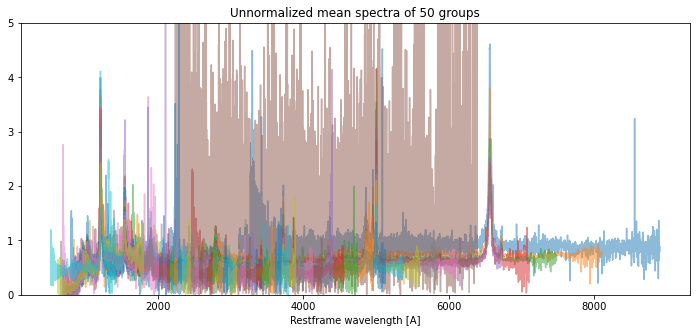

In [10]:
figure(figsize=(12,5))
for i in range(ngroups):
    jj = meanflux[i]>0
    plot(wave[jj], meanflux[i][jj], alpha=0.5)

title(f'Unnormalized mean spectra of {ngroups} groups')
xlabel('Restframe wavelength [A]')
ylim(0,5);

In [11]:
for i in range(1, ngroups):
    jj = (meanflux[i]>0) & (meanflux[i-1]>0) & (wave>1300)
    scale = np.median(meanflux[i-1][jj] / meanflux[i][jj])
    meanflux[i] *= scale

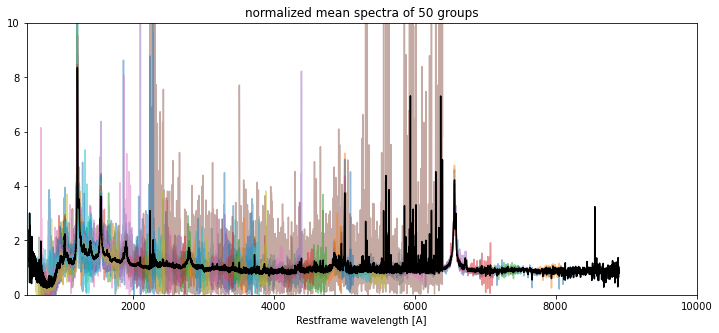

In [12]:
figure(figsize=(12,5))
for i in range(ngroups):
    jj = meanflux[i]>0
    plot(wave[jj], meanflux[i][jj], alpha=0.5)

jj = np.sum(meanflux>0, axis=0)>0
mflux = np.average(meanflux[:,jj], weights=(meanflux[:,jj]>0), axis=0)
plot(wave[jj], mflux, 'k-')

title(f'normalized mean spectra of {ngroups} groups')
xlabel('Restframe wavelength [A]')
ylim(0,10)
xlim(500, 10000);

In [13]:
%%time
#- Now, normalize the individual spectra to that mean spectrum

jj = np.sum(meanflux>0, axis=0)>0
mflux = np.zeros(nwave)
mflux[jj] = np.average(meanflux[:,jj], weights=(meanflux[:,jj]>0), axis=0)

normflux = flux.copy()
normivar = ivar.copy()
for i in range(nspec):
    kk = jj & (ivar[i]>0) & (flux[i] != 0)
    scale = np.median(mflux[kk] / flux[i][kk])
    normflux[i] *= scale
    normivar[i] /= scale**2
    if (i%1000) == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
CPU times: user 8.81 s, sys: 3.5 s, total: 12.3 s
Wall time: 12.3 s


In [14]:
#- New mean flux of the individual spectra
mflux = np.average(normflux, weights=normivar>0, axis=0)

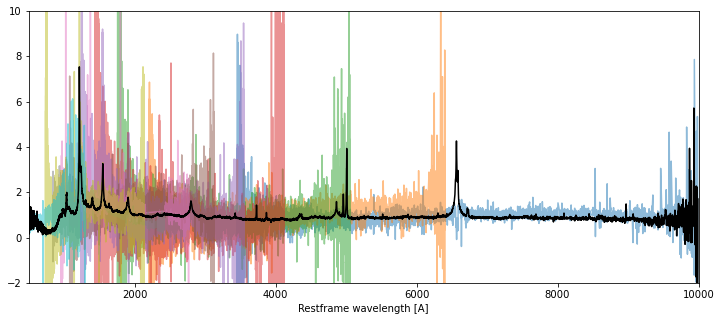

In [15]:
#- Plot 10 example spectra and the global mean

figure(figsize=(12,5))
for i in np.linspace(0, nspec-1, 10).astype(int):
    jj = normivar[i]>0
    plot(wave[jj], normflux[i][jj], alpha=0.5)

plot(wave, mflux, 'k-')

xlabel('Restframe wavelength [A]')
ylim(-2,10)
xlim(500, 10000);

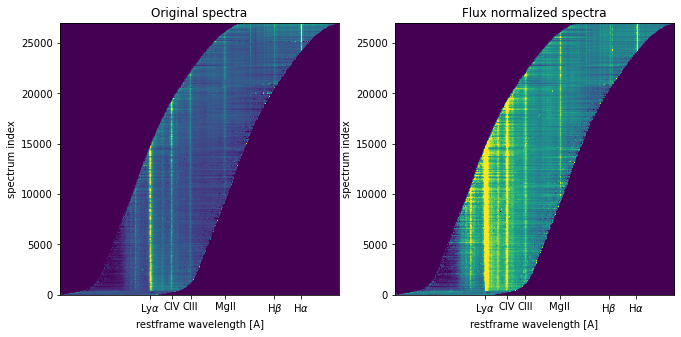

In [16]:
figure(figsize=(11,5))
subplot(121)
imshow(flux[0::10], vmin=0, vmax=2, aspect='auto', extent=(loglam[0], loglam[-1], 0, nspec))
ww = np.array([1216, 1549, 1909, 2798, 4861, 6563])
emission_lines = [r'Ly$\alpha$', 'CIV', 'CIII', 'MgII', r'H$\beta$', r'H$\alpha$']
xticks(np.log10(ww), emission_lines)
xlabel('restframe wavelength [A]')
ylabel('spectrum index')
title('Original spectra')

subplot(122)
imshow(normflux[0::10], vmin=0, vmax=2, aspect='auto', extent=(loglam[0], loglam[-1], 0, nspec))
ww = np.array([1216, 1549, 1909, 2798, 4861, 6563])
emission_lines = [r'Ly$\alpha$', 'CIV', 'CIII', 'MgII', r'H$\beta$', r'H$\alpha$']
xticks(np.log10(ww), emission_lines)
xlabel('restframe wavelength [A]')
ylabel('spectrum index')
title('Flux normalized spectra');

In [17]:
#- Save the results
import fitsio
outfile = 'normalized_spectra.fits'

fitsio.write(outfile, normflux, extname='FLUX', clobber=True)
fitsio.write(outfile, normivar, extname='IVAR')
fitsio.write(outfile, wave, extname='WAVE')
fitsio.write(outfile, loglam, extname='LOGLAMBDA')
fitsio.write(outfile, np.asarray(qsocat), extname='QSOCAT')

In [4]:
#- Example of reading the results back in

outfile = 'normalized_spectra.fits'

flux2 = fitsio.read(outfile, 'FLUX')
ivar2 = fitsio.read(outfile, 'IVAR')
wave2 = fitsio.read(outfile, 'WAVE')
loglam2 = fitsio.read(outfile, 'LOGLAMBDA')
qsocat = Table.read(outfile, 'QSOCAT')

In [5]:
print(flux2.shape)

(27001, 13511)
